In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sharppy.plot.skew as skew
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
from sharppy.io.spc_decoder import SPCDecoder
import xarray as xr
from metpy.calc import dewpoint_from_relative_humidity
import glob
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter, MultipleLocator
import pyart
import cartopy.crs as ccrs
import warnings; warnings.simplefilter("ignore")
import zipfile
from IPython.display import display, Markdown
import netCDF4 as nc
from sklearn.cluster import KMeans as kmeans
import seaborn as sns
import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as inset
from matplotlib.patches import Circle
from metpy.calc import storm_relative_helicity, bunkers_storm_motion
from metpy.units import units


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [82]:
def get_sounding(time, lat, lon, var_max):

    str_fmt = "/g/data/rt52/era5/pressure-levels/reanalysis/%s/%d/%s_era5_oper_pl_%s*.nc" 
    str_fmt_sfc = "/g/data/rt52/era5/single-levels/reanalysis/%s/%d/%s_era5_oper_sfc_%s*.nc"
    
   # print(time.replace(minute=0))
    
    z=xr.open_dataset(glob.glob(str_fmt % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    u=xr.open_dataset(glob.glob(str_fmt % ("u",time.year,"u",time.strftime("%Y%m01")))[0])["u"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    v=xr.open_dataset(glob.glob(str_fmt % ("v",time.year,"v",time.strftime("%Y%m01")))[0])["v"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    
    us=xr.open_dataset(glob.glob(str_fmt_sfc % ("10u",time.year,"10u",time.strftime("%Y%m01")))[0])["u10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    vs=xr.open_dataset(glob.glob(str_fmt_sfc % ("10v",time.year,"10v",time.strftime("%Y%m01")))[0])["v10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    zs=xr.open_dataset(glob.glob(str_fmt_sfc % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest") 
    ps=xr.open_dataset(glob.glob(str_fmt_sfc % ("sp",time.year,"sp",time.strftime("%Y%m01")))[0])["sp"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    
    p=z.level
    prof_pres = np.flip(p.values.squeeze())
    prof_hgt = np.flip(z.values.squeeze())
    prof_u = np.flip(u.values.squeeze())
    prof_v = np.flip(v.values.squeeze())
    agl_inds = prof_pres <= (ps.values)
    
    pres=np.insert(prof_pres[agl_inds], 0, ps.values)
    hght=np.insert(prof_hgt[agl_inds], 0, zs.values)
    u=np.insert(prof_u[agl_inds], 0, us.values)
    v=np.insert(prof_v[agl_inds], 0, vs.values)
    
    f = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"+time.strftime("%Y%m01")+"*.nc")[var_max].\
            sel({"time":time.replace(minute=0)}).interp({"lon":lon, "lat":lat},method="nearest")
    # print(var_max," (from wrf_non_parallel.py)=",f.values)
    
    return u, v, hght/9.8, pres/100., z, zs

def srh_test(u, v, z, p, d, time, rid, bunkers=True):
    rm, lm, m06 = bunkers_storm_motion(p*units.hectopascal,u*units.meter_per_second,v*units.meter_per_second,z*units.meter)
    # print("metyp umean06: ",m06)    
    # print("metyp bunkers LM: ",lm)
    # print("metyp bunkers RM: ",rm)   
    if bunkers:
        srh=storm_relative_helicity(z*units.meter, u*units.meter_per_second, v*units.meter_per_second, d*units.meter, bottom=0*units.meter,
                       storm_u=lm[0],storm_v=lm[1])
    else:
        u_storm, v_storm = storm_motion(time,rid)    
        srh=storm_relative_helicity(z*units.meter, u*units.meter_per_second, v*units.meter_per_second, d*units.meter, bottom=0*units.meter,
                       storm_u=u_storm*units.meter_per_second,storm_v=v_storm*units.meter_per_second)
    #print("metpy SRH: ",srh)  
    
    return srh
    
def trapz_int3d(var3d, p3d, cond):

    #Vertical intergration using the trapezoidal rule for finite integration. Scaled by the total difference in 
    # pressure between the top and bottom layers, such that a mass-weighted mean is the output.

    #Cond is a boolean array which gives the layers of interest

    #If cond is false for the whole first dimension, then NaN is returned at that point

    #If there is only one level of interest, then var3d at that level is returned

    #See Dean S. documentation for more info.

    x,j,k = var3d.shape
    result = np.zeros((j,k))
    for i in np.arange(x-1):
        p_layer = p3d[i+1] - p3d[i]
        v_layer = var3d[i+1] + var3d[i]
        layer = np.where( (cond[i+1] & cond[i]), v_layer*p_layer, 0)
        result = result + layer
    p_masked = np.ma.masked_where(~cond, p3d)
    var3d_masked = np.ma.masked_where(~cond, var3d)
    ptop = p_masked.min(axis=0)
    pbot = p_masked.max(axis=0)
    return np.where( (cond.sum(axis=0) == 1), var3d_masked.max(axis=0),\
        np.ma.filled(( 1 / (2 * (ptop - pbot) ) ) * result, np.nan) )

def my_srh_test(u, v, z, p, d, rid, p_weighted=True, bunkers=True):
    
    
    if bunkers:
        if p_weighted:
            umean06 = np.squeeze(trapz_int3d( u[np.newaxis][np.newaxis].T,\
                p[np.newaxis][np.newaxis].T, \
                np.array(z<= d)[np.newaxis][np.newaxis].T))
            vmean06 = np.squeeze(trapz_int3d( v[np.newaxis][np.newaxis].T,\
                p[np.newaxis][np.newaxis].T, \
                np.array(z<= d)[np.newaxis][np.newaxis].T))
        else:
            umean06 = np.mean(u[z<=d])
            vmean06 = np.mean(v[z<=d])        

        u6 = np.interp([d], z, u)[0]
        v6 = np.interp([d], z, v)[0]
        u0 = u[0]
        v0 = v[0]
        us6 = u6 - u0
        vs6 = v6 - v0
        tmp = 7.5 / (np.sqrt(np.square(us6) + np.square(vs6)))
        u_storm_right = umean06 + (tmp * vs6)
        v_storm_right = vmean06 - (tmp * us6)
        u_storm_left = umean06 - (tmp * vs6)
        v_storm_left = vmean06 + (tmp * us6)   
    else:
        u_storm, v_storm = storm_motion(time,rid)
        u_storm_left = u_storm_right = u_storm
        v_storm_left = v_storm_right = v_storm        
    
    # print("my Bunkers LM: ",u_storm_left, v_storm_left)
    # print("my Bunkers RM: ",u_storm_right, v_storm_right)
    
    hgt=z
    hgt_bot=0
    hgt_top=d
    u_ma = np.ma.masked_where(np.squeeze((hgt < hgt_bot) | (hgt > hgt_top) | (np.isnan(u)) | \
            (np.isnan(hgt_bot)) | (np.isnan(hgt_top)) | (np.isnan(hgt))), u)
    v_ma = np.ma.masked_where(np.squeeze((hgt < hgt_bot) | (hgt > hgt_top) | (np.isnan(v)) | \
            (np.isnan(hgt_bot)) | (np.isnan(hgt_top)) | (np.isnan(hgt))) , v)
    sru_left = u_ma - u_storm_left
    srv_left = v_ma - v_storm_left
    layers_left = (sru_left[1:] * srv_left[:-1]) - (sru_left[:-1] * srv_left[1:])
    srhe_left = abs(np.sum(layers_left))    
    # print("my SRH: ",srhe_left)
    
    return srhe_left
    
def storm_motion(time,rid):
    df=pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+rid+"_"+time.strftime("%Y%m%d")+"_"+time.strftime("%Y%m%d")+".csv")
    df_aws=pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+rid+"_"+time.strftime("%Y%m%d")+"_"+time.strftime("%Y%m%d")+"_aws.csv")
    try:
        speed, angle = df[df["uid"]==df_aws.set_index(pd.DatetimeIndex(df_aws["dt_utc"])).loc[time].uid].iloc[0][["speed","angle"]].values
    except:
        speed, angle = df[df["uid"]==df_aws.set_index(pd.DatetimeIndex(df_aws["dt_utc"])).loc[time].uid10].iloc[0][["speed","angle"]].values
    u = speed * np.sin(np.deg2rad(angle))
    v = speed * np.cos(np.deg2rad(angle))
    return u, v
    
details_list = [\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2006,9,24,1,41)], "rid":"2", "title":"a) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2009,11,20,3,6)], "rid":"2", "title":"b) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,3,6,3,30)], "rid":"2", "title":"c) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,6,17,0,25)], "rid":"2", "title":"d) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,11,18,7,4)], "rid":"2", "title":"e) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,45)], "rid":"2", "title":"f) Melbourne:  UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2012,2,26,9,11)], "rid":"2", "title":"g) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2013,3,21,3,45)], "rid":"2", "title":"h) Melbourne: UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2015,2,28,9,25)], "rid":"2", "title":"i) Melbourne:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2010,8,2,15,43)], "rid":"71", "title":"a) Sydney:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2012,8,10,4,21)], "rid":"71", "title":"b) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2013,2,23,13,43)], "rid":"71", "title":"c) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2014,10,14,11,39)], "rid":"71", "title":"d) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,3,1,4,34)], "rid":"71", "title":"e) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,12,16,2,3)], "rid":"71", "title":"f) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,1,14,4,20)], "rid":"71", "title":"g) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,6,4,3,42)], "rid":"71", "title":"h) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2017,4,9,8,3)], "rid":"71", "title":"i) Sydney: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2010,12,16,3,25)], "rid":"66", "title":"a) Amberley: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2011,1,18,5,5)], "rid":"66", "title":"b) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2011,10,7,19,22)], "rid":"50", "title":"c) Oakey: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2013,10,18,4,4)], "rid":"50", "title":"d) Oakey: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2013,11,23,9,45)], "rid":"66", "title":"e) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2014,1,23,4,52)], "rid":"50", "title":"f) Oakey UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2016,1,29,4,22)], "rid":"50", "title":"g) Oakey UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2016,12,18,4,14)], "rid":"66", "title":"h) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2018,2,13,7,5)], "rid":"50", "title":"i) Oakey: UTC"},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2007,10,27,9,3)], "rid":"27", "title":"a) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2008,12,9,6,18)], "rid":"27", "title":"b) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2010,12,7,9,27)], "rid":"27", "title":"c) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2011,11,8,9,47)], "rid":"27", "title":"d) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,1,29,4,42)], "rid":"27", "title":"e) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,11,30,8,33)], "rid":"27", "title":"f) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2014,10,31,7,52)], "rid":"27", "title":"g) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2015,12,7,11,20)], "rid":"27", "title":"h) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2017,12,18,11,30)], "rid":"27", "title":"i) "},\
       ]
 

In [83]:
metpy_srh_list = []
metpy_srh_storm_list = []
my_srh_list = []
my_srh_storm_list = []
times = []

for i in tqdm.tqdm(np.arange(len(details_list))):
    time = details_list[i]["time"][0]
    lat = details_list[i]["lat"]
    lon = details_list[i]["lon"]
    rid = details_list[i]["rid"]

    u, v, z, p, zf, zfs = get_sounding(time,lat,lon,"srh06_left")
    metpy_srh = np.array(srh_test(u,v,z,p,6000,time,rid,bunkers=True)[2])
    metpy_srh_storm = np.array(srh_test(u,v,z,p,6000,time,rid,bunkers=False)[2])
    my_srh = my_srh_test(u,v,z,p,6000,rid,p_weighted=False,bunkers=True)
    my_srh_storm = my_srh_test(u,v,z,p,6000,rid,p_weighted=False,bunkers=False)

    metpy_srh_list.append(metpy_srh)
    metpy_srh_storm_list.append(metpy_srh_storm)
    my_srh_list.append(my_srh)
    my_srh_storm_list.append(my_srh_storm)    
    
    times.append(time)

100%|██████████| 36/36 [03:14<00:00,  5.40s/it]


Text(0, 0.5, 'Metpy SRH calculation - left moving Bunkers storm')

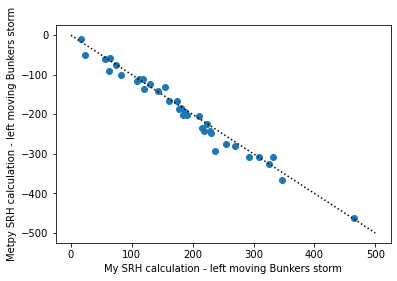

In [105]:
plt.plot(my_srh_list, metpy_srh_list, marker="o", linestyle="none")
plt.plot([0,500],[0,-500],color="k",ls=":")
plt.xlabel("My SRH calculation - left moving Bunkers storm")
plt.ylabel("Metpy SRH calculation - left moving Bunkers storm")

Text(0, 0.5, 'Metpy SRH calculation - radar-derived storm motion')

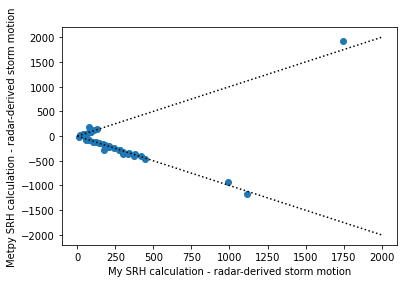

In [109]:
plt.plot(my_srh_storm_list, metpy_srh_storm_list, marker="o", linestyle="none")
plt.plot([0,2000],[0,-2000],color="k",ls=":")
plt.plot([0,2000],[0,2000],color="k",ls=":")
plt.xlabel("My SRH calculation - radar-derived storm motion")
plt.ylabel("Metpy SRH calculation - radar-derived storm motion")

(0.0, 500.0)

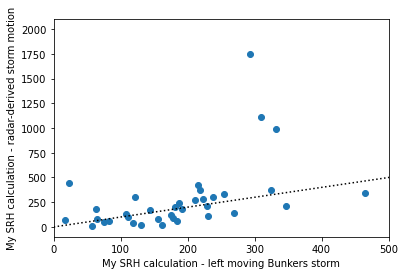

In [127]:
plt.plot(my_srh_list, my_srh_storm_list, marker="o", linestyle="none")
plt.ylabel("My SRH calculation - radar-derived storm motion")
plt.xlabel("My SRH calculation - left moving Bunkers storm")
plt.plot([0,2000],[0,2000],color="k",ls=":")
plt.xlim([0,500])

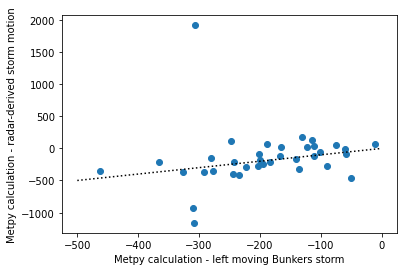

In [128]:
plt.plot(metpy_srh_list, metpy_srh_storm_list, marker="o", linestyle="none")
plt.ylabel("Metpy calculation - radar-derived storm motion")
plt.xlabel("Metpy calculation - left moving Bunkers storm")
plt.plot([-500,0],[-500,0],color="k",ls=":")


In [129]:
#pd.DataFrame({"Metpy bunkers":metpy_srh_list, "Metpy radar":metpy_srh_storm_list, "My bunkers":my_srh_list, "My radar":my_srh_storm_list},index=times).sort_values("My radar",ascending=False)